# ARIMA 
* A really local approach for trying to perform arima for the wheat prices of the Indian wheat market 

In [1]:
# Importing all the libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
import itertools
import statsmodels.api as sm

C:\Users\risha\AppData\Local\Temp\ipykernel_27244\2975203458.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size':12})
plt.style.use('ggplot')

            International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
Month                                                                                     
1949-01-01                                                112                             
1949-02-01                                                118                             
1949-03-01                                                132                             
1949-04-01                                                129                             
1949-05-01                                                121                             
...                                                       ...                             
1960-07-01                                                622                             
1960-08-01                                                606                             
1960-09-01                                                508                             

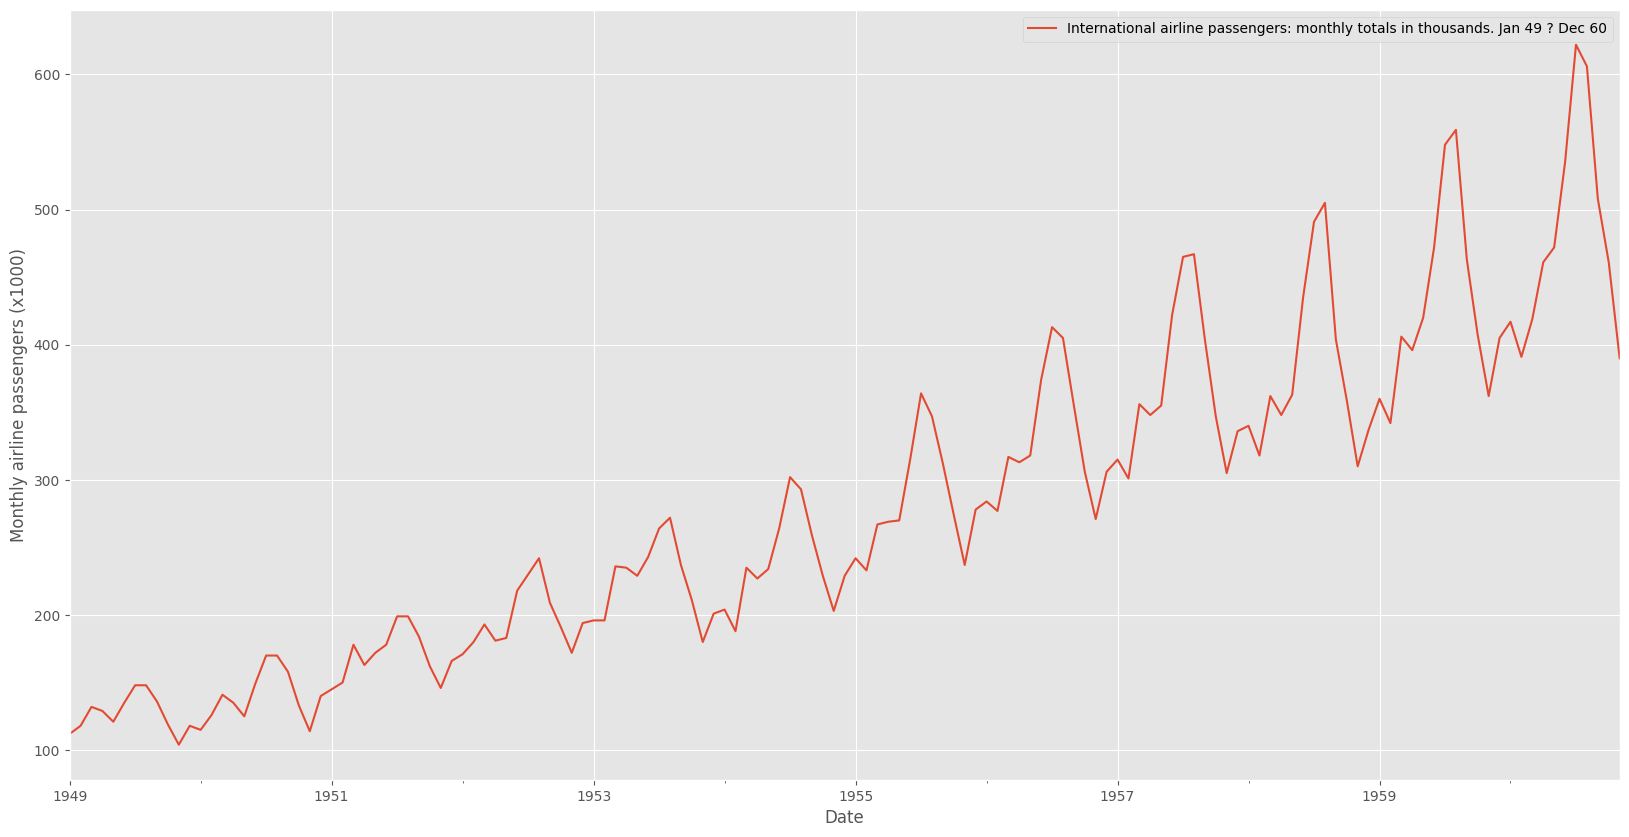

In [12]:
data = pd.read_csv('.\\arima-data.csv',engine='python',skipfooter=3)
data['Month'] = pd.to_datetime(data['Month'],format='%Y-%m')
data.set_index(['Month'],inplace=True)

print(data)
data.plot()
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.show()

In [18]:
# Define the d and q parameters to take any value betweent 0 and 1
q = d = range(0,2)
# Define the p parameter to take any value between 0 and 3
p = range(0,4)
# Generate all different combinations of p,q and q triplets
pdq = list(itertools.product(p,d,q))

# seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]
seasonal_pdq = [(x[0],x[1],x[2],12) for x in pdq]

print("Example of parameter combination for seasonal ARIMA")
print('SARIMAX: {} x {}'.format(pdq[1],seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1],seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2],seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2],seasonal_pdq[4]))

Example of parameter combination for seasonal ARIMA
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [20]:
train_data = data['1949-01-01':'1959-12-01']
test_data = data['1960-01-01':'1960-12-01']

In [24]:
warnings.filterwarnings('ignore')

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('SARIMAX{}x{} - AIC:{}'.format(param,param_seasonal,results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param,param_seasonal])
        except:
            continue

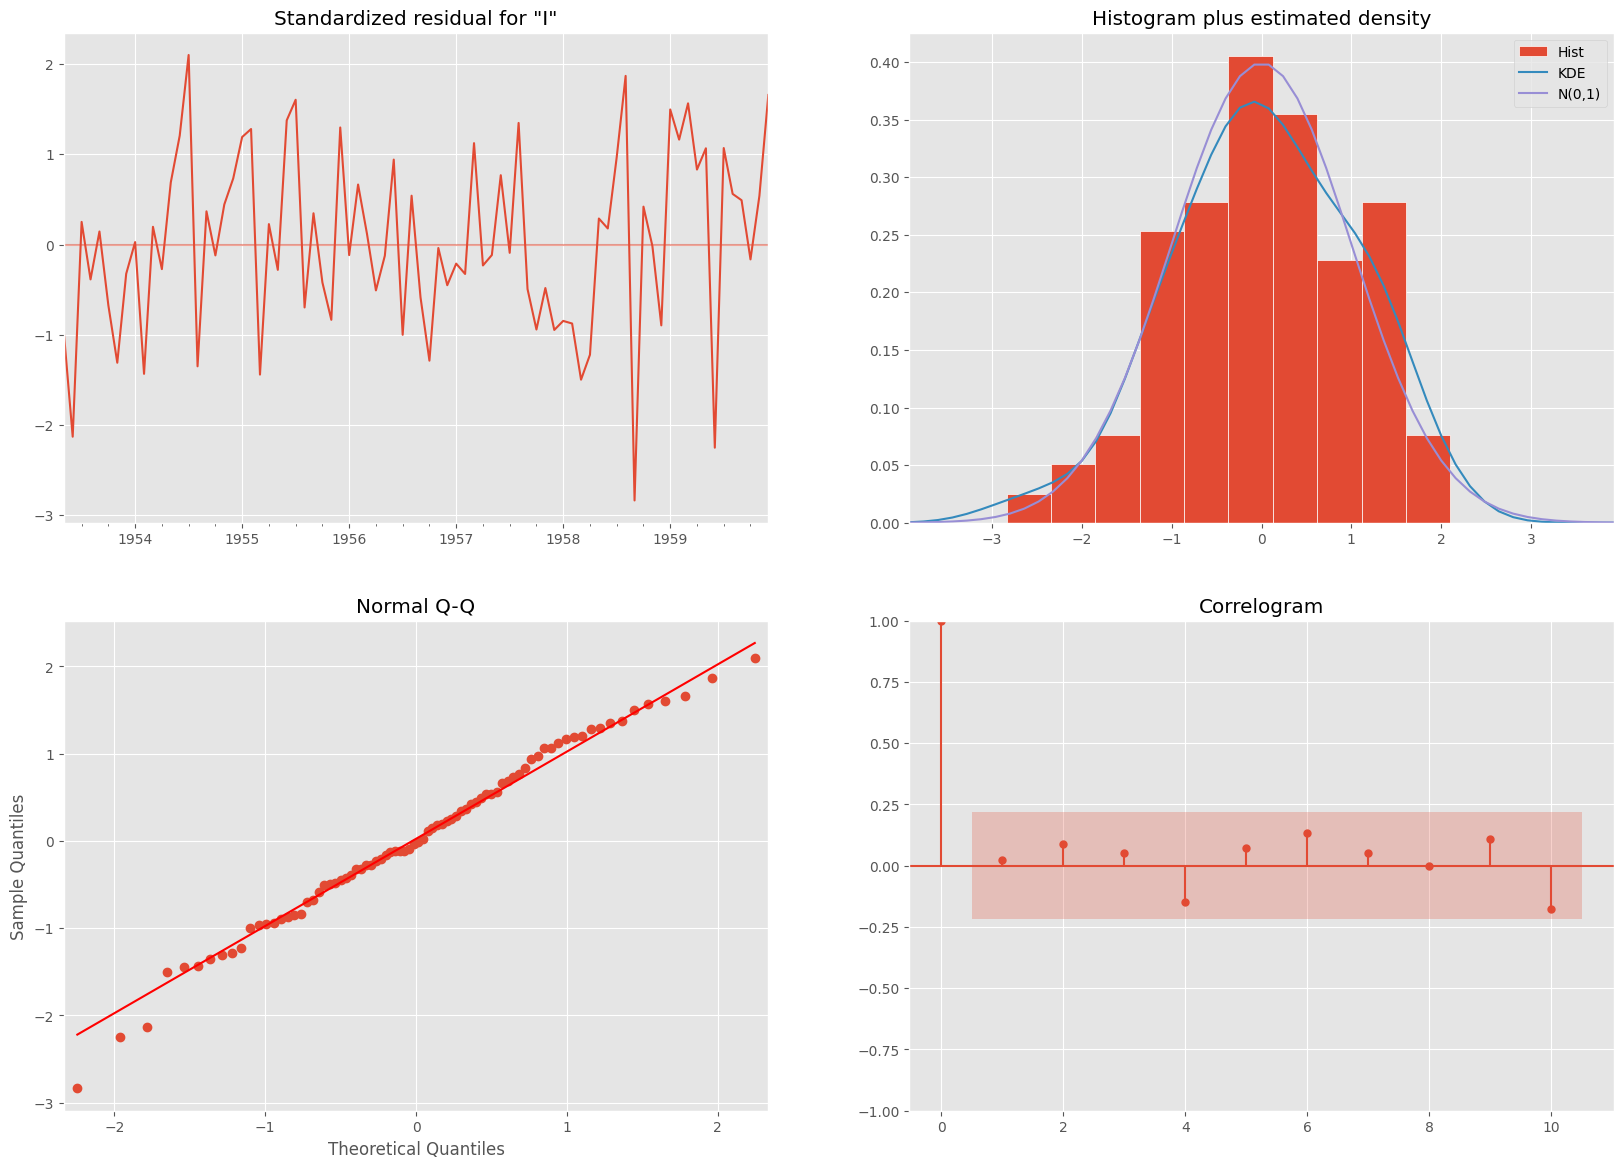

In [27]:
results.plot_diagnostics(figsize=(20,14))
plt.show()

In [31]:
pred0= results.get_prediction(start='1958-01-01',dynamic=True)
pred0_ci = pred0.conf_int()

In [32]:
pred1 = results.get_prediction(start='1958-01-01',dynamic=True)
pred1_ci = pred1.conf_int()

In [48]:
pred2 = results.get_forecast('1962-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['1960-01-01':'1960-12-01'])

1960-01-01    419.453045
1960-02-01    397.840206
1960-03-01    460.340787
1960-04-01    448.963299
1960-05-01    473.591217
1960-06-01    536.520811
1960-07-01    613.001264
1960-08-01    625.965534
1960-09-01    518.509407
1960-10-01    461.496112
1960-11-01    411.729280
1960-12-01    452.150637
Freq: MS, Name: predicted_mean, dtype: float64


TypeError: 'DatetimeIndex' object is not callable

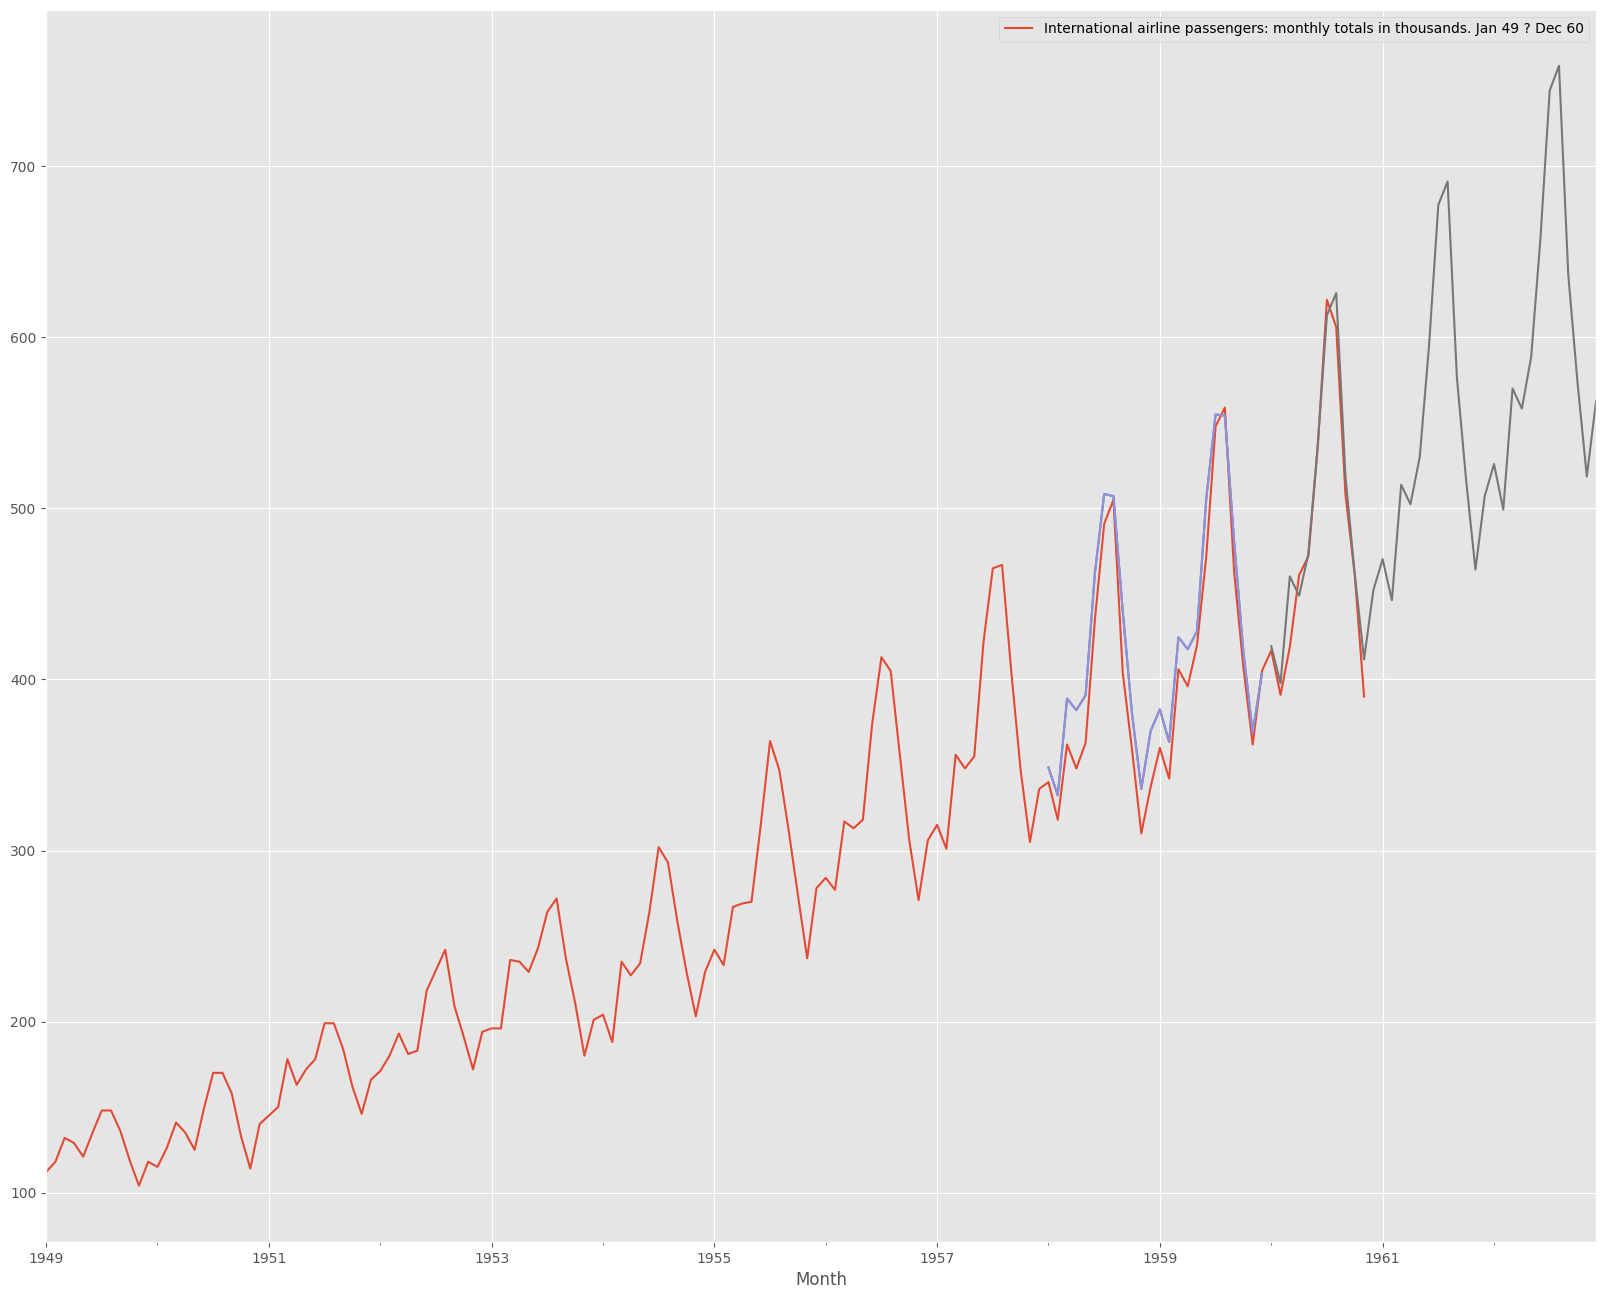

In [49]:
ax = data.plot(figsize=(20,16))
pred0.predicted_mean.plot(ax=ax,label='1-step-ahead Forecast(get_prediction,dynamic=False)')
pred1.predicted_mean.plot(ax=ax,label='Dynamic Forecast(get_prediction,dynamic=True)')
pred2.predicted_mean.plot(ax=ax,label='Dynamic Forecast(get_forecast)')
ax.fill_between(pred2_ci.index().values,pred2_ci.iloc[:,0],pred2_ci[:,1],color='k',alpha=.1)
plt.ylabel("Monthly Airline passengers (x1000)")
plt.xlabel("Date")
plt.legend()
plt.show()